# Week 10 


<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>



<div style="color:blue;font-style:italic">07.03.2022 - 11.03.2022</div>


<div style="background-color:rgba(256, 76, 76,0.4)",height="200">

<br>

<H4>Abstract</H4>

<br>

</div>

---

A possible approach to a bayesian model for LC-IMS-MS precursor features is a general linear model (GLM). In this week a GLM prototype was introduced into pystoms and a 3D visualization with python library plotly was implemented.

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Introduction</H4>
<br>
</div>

---






---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Methods and Material</H4>
<br>
</div>

---


```python3

```
---

<!-- <div style="background-color:white">

<img src="data/modelGraphviz.svg" >

</div>
<figcaption style="font-weight:bold;font-size:small">
Fig 1: Visualization of artificial Model spanning 10 submodels each receiving an independent dataset of normally distributed data of unknown mean. Visualization was created with python-graphviz <cite data-cite="graphviz"></cite>.
</figcaption> --> 

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Results</H4>
<br>
</div>

---


In [1]:
from pyproteolizard.data import PyTimsDataHandle
from pystoms.feature_loader_dda import FeatureLoaderDDA
from pystoms.modelsGLM import ModelGLM3D
import theano
import pymc as pm
import numpy as np
import plotly.io as pio
import arviz as az
pio.renderers.default = "sphinx_gallery"
# get raw data via proteolizard
data_handle = PyTimsDataHandle('/home/tim/Master/MassSpecDaten/M210115_001_Slot1-1_1_850.d/')
# precursors are listed in precursor table
precursor_table = data_handle.get_selected_precursors()
precursor_table.tail()



,Id,LargestPeakMz,AverageMz,MonoisotopicMz,Charge,ScanNumber,Intensity,Parent
159750,159751,622.025454,622.025454,NaN,NaN,580.739867,3415.0,63813
159751,159752,1221.987656,1222.591240,1221.987656,1.0,226.036453,3825.0,63842
159752,159753,622.028638,622.283194,622.028638,1.0,581.280292,2905.0,63842
159753,159754,922.008974,922.489243,922.008974,1.0,402.424060,2870.0,63890
159754,159755,1221.989765,1222.593349,1221.989765,1.0,227.225000,2574.0,63993


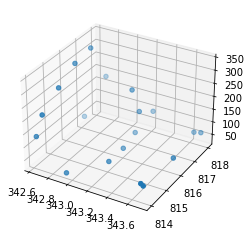

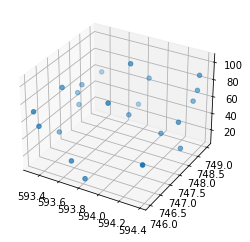

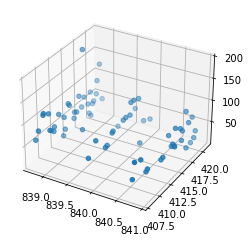

In [2]:
# ectract some features with random ids
features = [200,1900,230]

feature_data = []
charges = []

for feature_id in features:
    feature = FeatureLoaderDDA(data_handle,feature_id)
    # estimate feature hull boundaries with averagine model for isotopic pattern and gaussian model for IMS
    data_tmp = feature.load_hull_data_3d(ims_model="gaussian",plot_feature=True)
    feature_data.append(data_tmp)
    charges.append(feature.charge)
    



In [4]:
myModel.PI.eval().shape

WARNING (aesara.tensor.basic_opt): Optimization Warning: The Op gamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


(6,)

In [3]:
# first feature data is needed to declare the model
 
s = feature_data[0]["Scan"].values
m = feature_data[0]["Mz"].values
i = feature_data[0]["Intensity"].values
z = charges[0]

myModel = ModelGLM3D(s.size,6,z,i,s,m,"",None)

/home/tim/miniconda3/envs/proteolizard/lib/python3.8/site-packages/pymc/data.py:647: FutureWarning:

The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.



In [4]:
traces = []
for z,feature in zip(charges,feature_data):
  scans = feature["Scan"].values
  mzs = feature["Mz"].values
  intensities = feature["Intensity"].values
  with myModel as model:
    # set data with current feature data
    pm.set_data({"charge":z,
                 "scan":scans,
                 "intensity":intensities,
                 "mz":np.tile(mzs,(6,1)).T,
                 "peak_num":6,
                 "num_observed":scans.size # awful but mzs currently needed as column
    })
    # evalaution is driver method for pm.sample and plotting,
    # if resample not true, model would not sample if it was 
    # already fitted
    model.evaluation(return_inferencedata = True)
    traces.append(model.idata)

WARNING (aesara.tensor.basic_opt): Optimization Warning: The Op gamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I_t, I_s, MS_mz, MS_s, alpha, me]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
/home/tim/miniconda3/envs/proteolizard/lib/python3.8/site-packages/pymc/backends/arviz.py:58: UserWarning:

Could not extract data from symbolic observation obs

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I_t, I_s, MS_mz, MS_s, alpha, me]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
/home/tim/miniconda3/envs/proteolizard/lib/python3.8/site-packages/pymc/backends/arviz.py:58: UserWarning:

Could not extract data from symbolic observation obs

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I_t, I_s, MS_mz, MS_s, alpha, me]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
/home/tim/miniconda3/envs/proteolizard/lib/python3.8/site-packages/pymc/backends/arviz.py:58: UserWarning:

Could not extract data from symbolic observation obs

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [15]:
myModel.pi2.eval().shape

(73,)

In [ ]:
with myModel as model:
  pm.set_data({"charge":z,
                 "scan":scans[:10],
                 "intensity":intensities[:10],
                 "mz":np.tile(mzs[:10],(6,1)).T,
                 "peak_num":6,
                 "num_observed":scans[:10].size # awful but mzs currently needed as column
    })

In [ ]:
with myModel as model:
  ppc = pm.sample_posterior_predictive(traces[0])

In [ ]:
test_x-test_y

In [ ]:
traces[1+].constant_data

In [ ]:
with myModel as model:
  pm.set_data({"charge":z,
                 "scan":scans[:5],
                 "intensity":intensities[:5],
                 "mz":np.reshape(mzs[:5],(mzs[:5].size,1)), # awful but mzs currently needed as column
    })
  ppc = pm.sample()

In [ ]:
ppc["alpha"].shape

In [ ]:
test_i_d = az.from_pymc3(posterior_predictive =ppc,model=myModel)
#del test_i_d.observed_data
test_i_d

In [ ]:
import arviz as az
with myModel as model:
  az.concat(traces[0], az.from_pymc3(posterior_predictive=ppc).posterior_predictive, inplace=True)

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Conclusion and Outlook</H4>
<br>
</div>


---



---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>References</H4>
<br>
</div>


---

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>To Do</H4>
<br>
</div>


---

Next Steps:

1. Parallelized GLM model
2. Model Evaluation for GLM in pystoms
3. Feature Manager -> handling many features at once
4. Test Model on GPU

5. CPU and GPU breakdown for bigger models in pymc4







---